# THE WAR AGAINST HEART ARRHYTHMIA

In [1]:
import numpy as np
from scipy.optimize import fsolve
import math
import pywt
import time
import cython
import pandas as pd
import scipy.signal
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy import interpolate
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from statsmodels.tsa.stattools import acf
import random
from collections import deque
import statsmodels.graphics.tsaplots as st
from scipy import special
from scipy.signal import find_peaks
import sklearn
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy import integrate
import pyspeckit
from pyspeckit import moments
import arch
from arch.unitroot import VarianceRatio

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Signal preprocessing:

1. Subtract the mean
2. Five order moving average filtering
3. High Pass Filtering with f = 1 Hz (Drift Suppression)
4. low-pass Butterworth filtering with fc = 30 Hz

In [2]:
def signal_creator(MIT_signal_whole):
    MIT_data = []
    for i in range(len(MIT_signal_whole[0])):
        MIT_data.append(MIT_signal_whole[0][i][0])
    MIT_data = np.array(MIT_data)
    nulls = np.isnan(MIT_data)
    l=[]
    for i in range(len(nulls)):
        if nulls[i] == True:
            MIT_data[i] = 0
            l.append(i) 
    MIT_data[l] = np.mean(MIT_data)
    #plt.plot(MIT_data)
    #plt.xlim(0,600)
    return MIT_data


def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l) 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def starting_point(signal,t,fs):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

def signal_preprocessor(data,time,uu,mm):
    mean = np.mean(data)
    data = data - mean
    
    data = moving_average(data,5)
    #plt.plot(time,data)
    #plt.xlim(0,10)
    data = np.array(data)
    
    data = butter_highpass_filter(data, 1, uu, 5)
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,data)
    
    MIT_signal = butter_lowpass_filter(data, 1, mm, 5)
    fs=30
    time = np.arange(MIT_signal.size)/fs
    time = time/10
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,MIT_signal)

    return MIT_signal,time

def ready_signal(directory,freq1):
    s = wfdb.io.rdsamp(directory)
    s = signal_creator(s)
    t = np.arange(s.size)/freq1
    s = wfdb.processing.normalize_bound(s, lb=-1, ub=1)
    s,t= signal_preprocessor(s,t,freq1,30)
    return s,t

def starting_point_end(signal,t):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = t[index_M[0][0]:-1]
    return signal_start,time_M

def for_TCI(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(ss[i][j])
            time.append(tt[i][j])
    return values,time

def start_end_ext(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            x,y = starting_point_end(ss[i][j],tt[i][j])
            values.append(x)
            time.append(y)
    return values,time

## Signals and Times arrays:

In [3]:
signals = []
times = []
str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]
for i in MIT_str:
    x,y = ready_signal(str1+i,360)
    signals.append(x)
    times.append(y)

In [4]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]
for i in cudb_str:
    x,y = ready_signal(str2+i,250)
    signals.append(x)
    times.append(y)

In [5]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]
for i in vfdb_str:
    x,y = ready_signal(str3+i,250)
    signals.append(x)
    times.append(y)

In [6]:
def for_sigmar(s,t):
    sigs = []
    tims = []
    for i in s:
        x = np.array_split(i,int(len(i)/3300))
        sigs.append(x)
    for i in t:
        y = np.array_split(i,int(len(i)/3300))
        tims.append(y)
    return sigs,tims

In [7]:
ss,tt = for_sigmar(signals,times)

In [8]:
sm,tm = start_end_ext(ss,tt)

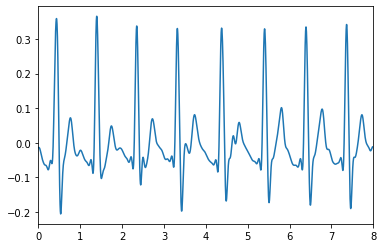

In [9]:
plt.xlim((0, 8))
#plt.ylim((930,1050))
plt.plot(tt[2][0][0:2400],ss[2][0][0:2400])

In [10]:
for i in range(0,105):
    for j in range(len(ss[i])):
        if len(ss[i][j])!=len(tt[i][j]):
            print("oops")    ##Checking if time and signal are the same size, and they are!

In [11]:
for i in range(len(ss)):
    print("Signal number: ",i+1,"Number of signals: ",len(ss[i]))

Signal number:  1 Number of signals:  196
Signal number:  2 Number of signals:  196
Signal number:  3 Number of signals:  196
Signal number:  4 Number of signals:  196
Signal number:  5 Number of signals:  196
Signal number:  6 Number of signals:  196
Signal number:  7 Number of signals:  196
Signal number:  8 Number of signals:  196
Signal number:  9 Number of signals:  196
Signal number:  10 Number of signals:  196
Signal number:  11 Number of signals:  196
Signal number:  12 Number of signals:  196
Signal number:  13 Number of signals:  196
Signal number:  14 Number of signals:  196
Signal number:  15 Number of signals:  196
Signal number:  16 Number of signals:  196
Signal number:  17 Number of signals:  196
Signal number:  18 Number of signals:  196
Signal number:  19 Number of signals:  196
Signal number:  20 Number of signals:  196
Signal number:  21 Number of signals:  196
Signal number:  22 Number of signals:  196
Signal number:  23 Number of signals:  196
Signal number:  24 N

In [12]:
def annotation_symbols(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.aux_note)
    return np.array(ann_list)

def annotation_locations(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.sample)
    return np.array(ann_list)

In [13]:
ann_list =[]
ann_locations = []

str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]

for i in MIT_str:
    ann_list.append(annotation_symbols(str1,i))
    ann_locations.append(annotation_locations(str1,i))

In [14]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]

for i in cudb_str:
    ann_list.append(annotation_symbols(str2,i))
    ann_locations.append(annotation_locations(str2,i))

In [15]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]

for i in vfdb_str:
    ann_list.append(annotation_symbols(str3,i))
    ann_locations.append(annotation_locations(str3,i))

In [16]:
ann_list=np.array(ann_list)
ann_locations = np.array(ann_locations)

In [17]:
ann_list

array([array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['', '(N', '', ..., '', '', ''], dtype='<U4'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U2'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U6'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '',

In [18]:
ann_locations

array([array([    18,     77,    370, ..., 649484, 649734, 649991]),
       array([     7,     83,    396, ..., 649004, 649372, 649751]),
       array([    68,    136,    410, ..., 649244, 649553, 649852]),
       array([    21,    265,    575, ..., 649195, 649534, 649875]),
       array([    36,     73,    316, ..., 649300, 649580, 649876]),
       array([    67,    197,    459, ..., 649221, 649471, 649740]),
       array([    83,    229,    351, ..., 649162, 649340, 649791]),
       array([    47,     95,    272, ..., 649129, 649441, 649748]),
       array([    23,     88,    442, ..., 649170, 649471, 649769]),
       array([    18,    111,    343, ..., 649378, 649663, 649931]),
       array([    31,    197,    489, ..., 649148, 649441, 649724]),
       array([    15,    124,    382, ..., 649361, 649626, 649883]),
       array([    22,    170,    583, ..., 649364, 649675, 649994]),
       array([    21,    310,    726, ..., 649261, 649523, 649783]),
       array([    44,    161,    5

In [19]:
wfdb.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [20]:
wfdb.io.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed qrs detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


In [21]:
def fib_location(lis,loc):
    listlist = []
    listmist = []
    for i in range(len(lis)):
        for j in range(len(lis[i])):
            if lis[i][j]== '(VF' or lis[i][j] == '(VFL' or lis[i][j] == '(SVTA' or lis[i][j] == '(VT':
                for k in range(len(ann_list[i][j+1:-1])):
                    if ann_list[i][j+k+1] != '':
                        lastone = loc[i][j+k]
                        duration = lastone - loc[i][j-1]
                        break
                if i <=47:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Duration: ",duration/300,"s"," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", ((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])),"until: ",((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append(((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append(((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                elif 47 < i < 83: 
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                elif i >= 83:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
    return np.array(listlist),np.array(listmist)

In [22]:
VFVT_labels = [0.0]*14236
VFVT_labels = np.array(VFVT_labels)
Y_loc= fib_location(ann_list,ann_locations)

Signal number:  7  Type:  (VT  Location:  63624  Duration:  1.7866666666666666 s  Location in Signal division =  19  Location in vertical labels =  1195 until:  1195
Signal number:  14  Type:  (SVTA  Location:  251900  Duration:  5.233333333333333 s  Location in Signal division =  75  Location in vertical labels =  2623 until:  2624
Signal number:  24  Type:  (VT  Location:  39210  Duration:  2.2066666666666666 s  Location in Signal division =  11  Location in vertical labels =  4519 until:  4519
Signal number:  24  Type:  (VT  Location:  226766  Duration:  1.7166666666666666 s  Location in Signal division =  68  Location in vertical labels =  4576 until:  4576
Signal number:  24  Type:  (VT  Location:  340338  Duration:  3.0 s  Location in Signal division =  102  Location in vertical labels =  4610 until:  4610
Signal number:  24  Type:  (VT  Location:  385419  Duration:  1.9133333333333333 s  Location in Signal division =  116  Location in vertical labels =  4624 until:  4624
Signal 

Signal number:  36  Type:  (VT  Location:  64513  Duration:  1.22 s  Location in Signal division =  19  Location in vertical labels =  6879 until:  6879
Signal number:  36  Type:  (VT  Location:  443157  Duration:  1.24 s  Location in Signal division =  133  Location in vertical labels =  6993 until:  6993
Signal number:  37  Type:  (VT  Location:  154940  Duration:  2.09 s  Location in Signal division =  46  Location in vertical labels =  7102 until:  7102
Signal number:  39  Type:  (SVTA  Location:  146963  Duration:  1.92 s  Location in Signal division =  44  Location in vertical labels =  7492 until:  7492
Signal number:  39  Type:  (SVTA  Location:  148195  Duration:  1.6933333333333334 s  Location in Signal division =  44  Location in vertical labels =  7492 until:  7492
Signal number:  39  Type:  (SVTA  Location:  149531  Duration:  2.0933333333333333 s  Location in Signal division =  45  Location in vertical labels =  7493 until:  7493
Signal number:  39  Type:  (SVTA  Location

Signal number:  87  Type:  (VT  Location:  238134  Location in Signal division =  72  Location in vertical labels =  11212 until:  11212
Signal number:  87  Type:  (VT  Location:  238884  Location in Signal division =  72  Location in vertical labels =  11212 until:  11212
Signal number:  87  Type:  (VT  Location:  239615  Location in Signal division =  72  Location in vertical labels =  11212 until:  11212
Signal number:  87  Type:  (VT  Location:  240326  Location in Signal division =  72  Location in vertical labels =  11212 until:  11212
Signal number:  87  Type:  (VT  Location:  241038  Location in Signal division =  72  Location in vertical labels =  11212 until:  11212
Signal number:  87  Type:  (VT  Location:  241769  Location in Signal division =  73  Location in vertical labels =  11213 until:  11213
Signal number:  87  Type:  (VT  Location:  281499  Location in Signal division =  85  Location in vertical labels =  11225 until:  11225
Signal number:  87  Type:  (VT  Location:

In [23]:
len(Y_loc[0])

306

In [24]:
i = 0
counter = 0
while 3 > 2:
    for l in range(Y_loc[0][i],Y_loc[1][i]+1):
        VFVT_labels[l] = 1.0
        counter+=1
    i+=1
    if i == 305:
        break

In [25]:
VFVT_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
lismis = []
for i in range(len(VFVT_labels)):
    if VFVT_labels[i] == 1: 
        lismis.append(i)

In [27]:
len(lismis)

283

In [28]:
osmosis = []
for i in range(len(VFVT_labels)):
    if VFVT_labels[i] == 0: 
        osmosis.append(i)

In [29]:
len(osmosis)

13953

# Time parameter

In [30]:
t_cst = len(ss[0][0])/tt[0][0][-1]
t_cst  ##number of signal points in 1 second

300.09047044632086

## Parameter 1: TCI

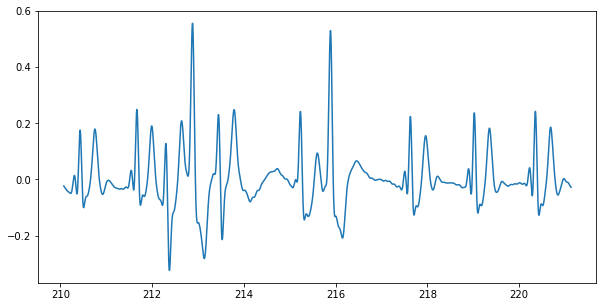

In [41]:
ss[6][19].size
tt[6][19].size
plt.figure(figsize=(10,5))
plt.plot(tt[6][19],ss[6][19])

In [42]:
def binary_td(signal,m,n):
    threshold = np.arange(n-m).astype("float")
    k = m
    s = m
    z = 0
    binary_list = []
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(signal[int(np.ceil(m*300)):int(np.ceil((m+1)*300))])
        i+=1
        m+=1
    for l in threshold:
        p = 0
        for j in signal[int(np.ceil(k*300)):int(np.ceil((k+1)*300))]:
            if j < l :
                binary_list.append(0)
            else: 
                binary_list.append(1)
        k+=1
    return np.array(binary_list),threshold

array([0, 0, 0, ..., 0, 0, 0])

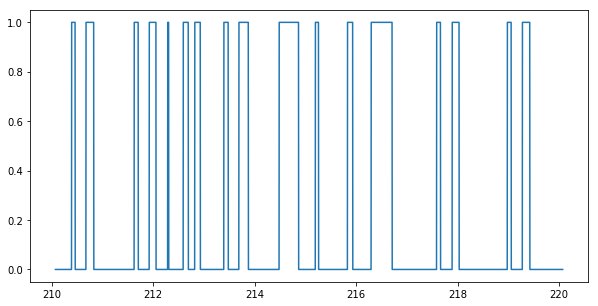

In [43]:
binlist,thd = binary_td(ss[6][19],0,10)
plt.figure(figsize=(10,5))
plt.plot(tt[6][19][0:10*300],binlist)
binlist[300:2700]

In [44]:
def TCI(binlist,thd,m,n):
    pulses = [0]*(n-m+2)
    q = 0
    p = 300
    ## pulse calculation:
    k=0
    for i in range(len(thd)):
        bin2 = binlist[q:p]
        for i in range(len(bin2)-1):
            if bin2[i]!=bin2[i+1]:
                pulses[k]+=1
        pulses[k] = pulses[k]/2
        k+=1
        q+=300
        p+=300
    q = 0
    p=900
    k=0
    t1_idx = 0
    t2_idx = 0
    t3_idx = 0
    t4_idx = 0
    TCI=[]
    for l in range(len(thd)-2):
        countidx1 = 0
        countidx2 = 0
        countidx3 = 0
        countidx4 = 0
        bin2 = binlist[q:p]
        
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx1+=1
                if countidx1/2 == pulses[k]:
                    t1_idx = f+q
                    break
        h1 = q+300
        bin2=binlist[h1:p]
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t2_idx = h1+f+1
                break
                    
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx3 +=1
                if countidx3/2 == pulses[k+1]:
                    t3_idx = f+h1
                    break
        h2 = q+600            
        bin2 =binlist[h2:p]             
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t4_idx = f+1+h2
                break
        t1 = (h1-t1_idx)/300
        t2 = (t2_idx-h1)/300
        t3 = (h2 - t3_idx)/300
        t4 = (t4_idx-h2)/300
        
        if t1+t2 == 0:
            TCI.append(0)
        elif t3+t4==0:
            TCI.append(0)
        else:
            form1 = (pulses[k+1]-1)+(t2/(t1+t2))+(t3/(t3+t4))
            if form1 == 0:
                TCI.append(0)
            else:
                form2=1000/form1
                TCI.append(form2)
            q+=300
            p+=300
            k+=1
    return np.array(TCI)

In [45]:
sr,tr = for_TCI(ss,tt)

In [46]:
binlist,thd = binary_td(sr[14040],1,9)
TCI(binlist,thd,2,8)

array([216.60049857, 252.52242152, 236.70197538, 257.97063104,
       227.52344181, 255.05350773])

## TCI Tests:

#### With VF-VT :

In [188]:
counter = 0
for i in lismis:
    binlist,thd = binary_td(sr[i],1,9)
    x = TCI(binlist,thd,2,8)
    count2 = 0
    for i in x:
        if i < 400:
            count2 +=1
    if count2 > 2:
        counter+=1

In [189]:
counter

136

In [190]:
counter/len(lismis)

0.48056537102473496

#### Without VF-VT :

In [191]:
counter = 0
for i in osmosis:
    binlist,thd = binary_td(sr[i],1,9)
    x = TCI(binlist,thd,2,8)
    count2 = 0
    for i in x:
        if i < 400:
            count2 +=1
    if count2 <= 2:
        counter+=1

In [192]:
counter

9422

In [193]:
counter/len(osmosis)

0.6752669676772021

## TCI Extraction:

In [ ]:
def TCI_ext(ss):
    values = []
    for i in range(len(ss)):
        binlist,thd = binary_td(ss[i],1,9)
        values.append(TCI(binlist,thd,2,8))
    return np.array(values)

In [ ]:
TCI_array = TCI_ext(sr)

In [ ]:
TCI_array[14040] ## Sample VF

In [ ]:
l1,l2,l3,l4,l5,l6 = [],[],[],[],[],[]
for i in TCI_array:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])
    l4.append(i[3])
    l5.append(i[4])
    l6.append(i[5])
    
l1 = pd.DataFrame(l1)
l2 = pd.DataFrame(l2)
l3 = pd.DataFrame(l3)
l4 = pd.DataFrame(l4)
l5 = pd.DataFrame(l5)
l6 = pd.DataFrame(l6)

ll = []
ll.append(l1)
ll.append(l2)
ll.append(l3)
ll.append(l4)
ll.append(l5)
ll.append(l6)

TCI_DF = pd.concat(ll,axis=1)
TCI_DF.columns = ["TCI_1","TCI_2","TCI_3","TCI_4","TCI_5","TCI_6"]

In [ ]:
TCI_DF

In [ ]:
TCI_DF.to_csv("TCI.csv",sep=',')

# Parameter 2: ACF Algorithm

In [194]:
qrs_inds = processing.xqrs_detect(sig=sm[14040][0:2400], fs=41)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


14

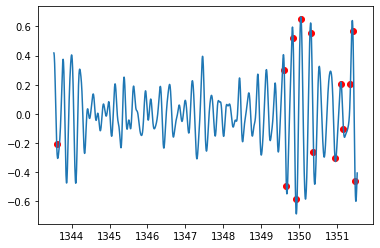

In [195]:
plt.plot(tm[14040][0:2400],sm[14040][0:2400])
plt.scatter(tm[14040][qrs_inds],sm[14040][qrs_inds],color="red")
x = int(len(qrs_inds))
x

In [196]:
ser = acf(ss[2][0][0:2400],nlags=x,alpha=0.01)

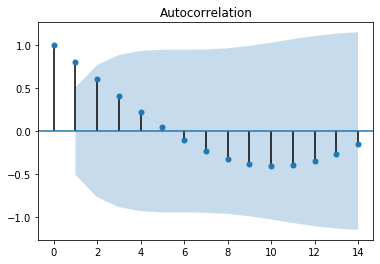

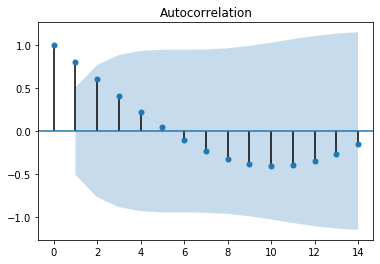

In [197]:
st.plot_acf(ser[0])

In [198]:
vr = VarianceRatio(ser[0])
vr.overlap=False
vr.stat

2.558789314777398

In [199]:
def ACF_test(signal):
    qrs_inds = processing.xqrs_detect(sig=signal, fs=41)
    x = int(len(qrs_inds))
    ser = acf(signal,nlags=int(x*3),alpha=0.95)
    q = []
    for i in range(len(ser[1])):
        q.append(ser[1][i][1])
    q=np.array(q)
    vr = VarianceRatio(q)
    vr.overlap=False
    return vr.stat

In [200]:
ACF_test(sm[0][0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.



The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



7.339132504130635

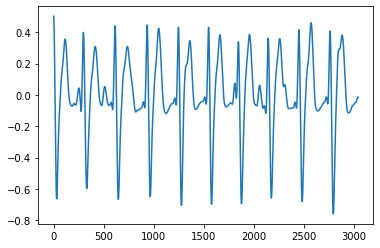

In [201]:
plt.plot(sm[196*7])

## ACF Test:

#### For VFVT :

In [202]:
%%capture
counter=0
for i in lismis:
    if ACF_test(sm[i][0:2400]) <= 6.61:
        counter+=1

In [203]:
counter

81

In [204]:
counter/len(lismis)

0.2862190812720848

In [208]:
%%capture
counter=0
for i in osmosis:
    if ACF_test(sm[i][0:2400]) >= 6.61:
        counter+=1

In [209]:
counter

6924

In [210]:
counter/len(osmosis)

0.4962373683078908

## ACF Extraction:

In [211]:
def ACF_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(ACF_test(ss[i][0:2400]))
        print(i)
    return np.array(values)

In [212]:
ACF = ACF_ext(sm)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
0
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
1
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
2
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
3
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
4
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
5
Learning initial signal parameters...
Found 8 beats 


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



10
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
11
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
12
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
13
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
14
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
15
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
16
Learning initial signal parameters...
Found


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




32
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
33
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
34
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
35
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
36
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
37
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
38
Learning initial signal parameters...
Foun


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Running QRS detection...
QRS detection complete.
44
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
45
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
46
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
47
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
48
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
49
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection comple


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



55
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
56
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
57
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
58
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
59
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
60
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
61
Learning initial signal parameters...
Found


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
67
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
68
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
69
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
70
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
71
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
72
Learning initial signal parameters...
Found 8 beats during learning. Initializing u


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
78
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
79
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
80
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
81
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
82
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
83
Learning initial signal parameters...
Found 8 


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
88
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
89
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
90
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
91
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
92
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
93
Learning initial signal parameters...
Found 8 beats during learning. Initializing us


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




99
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
100
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
101
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
102
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
103
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
104
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
105
Learning initial signal parameters..


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
110
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
111
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
112
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
113
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
114
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
115
Learning initial signal parameters...
Found 8 beats during learning. Initiali


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Running QRS detection...
QRS detection complete.
122
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
123
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
124
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
125
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
126
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
127
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection 


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
132
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
133
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
134
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
135
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
136
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
137
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
138
Learning ini


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Running QRS detection...
QRS detection complete.
144
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
145
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
146
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
147
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
148
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
149
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection 


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
154
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
155
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
156
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
157
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
158
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
159
Learning initial signal parameters...
Found 8 beats during learning. Initializ


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




161
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
162
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
163
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
164
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
165
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
166
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
167
Learning initial signal parameters.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
180
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
181
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
182
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
183
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
184
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
185
Learning initial signal parameters...
Found 8 beats during learning. Initializ


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
190
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
191
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
192
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
193
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
194
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
195
Learning initial signal parameters...
Found 8 beats during learning. Initiali


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
199
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
200
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
201
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
202
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
203
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
204
Learning initial signal parameters...
Found 8 beats during learning. Initiali


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




207
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
208
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
209
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
210
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
211
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
212
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
213
Learning initial signal parameters.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
215
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
216
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
217
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
218
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
219
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
220
Learning initial signal parameters...
Found 8 beats during learning. Initializ


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.




Running QRS detection...
QRS detection complete.
224
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
225
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
226
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
227
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
228
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
229
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection 


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.


The length of y is not an exact multiple of 2, and so the final
1 observations have been dropped.



QRS detection complete.
234
Learning initial signal parameters...

KeyboardInterrupt: 

In [ ]:
ACF

In [ ]:
ACF_DF = pd.DataFrame(ACF)
ACF_DF.columns = ["ACF"]

In [ ]:
ACF_DF

In [ ]:
ACF

## Parameter 3: VF Filter

In [213]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def VF_Filter_leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [214]:
VF_Filter_leakage(ss[2][0][0:2400],int(get_points(ss[2][0][0:2400],300)),200,500)

0.6344872267021999

## VF Filter Test:

#### For VF-VT:

In [215]:
counter = 0
for i in lismis:
    if  VF_Filter_leakage(sm[i][0:2400],int(get_points(sm[i][0:2400],300)),200,500) < 0.625:
        counter+=1
        
counter

121

In [216]:
counter/len(lismis)

0.4275618374558304

#### Without VF-VT:

In [217]:
counter = 0
for i in osmosis:
    if  VF_Filter_leakage(sm[i][0:2400],int(get_points(sm[i][0:2400],300)),200,500) >= 0.625:
        counter+=1
        
counter

11367

In [218]:
counter/len(osmosis)

0.8146635132229628

## VF Filter Extraction

In [219]:
def VFF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(VF_Filter_leakage(ss[i][j][0:2400],int(get_points(ss[i][j][0:2400],300)),200,500))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["VFF"]
    return v

In [220]:
VFF_DF = VFF_ext(ss)

KeyboardInterrupt: 

## Parameter 4: Spectral Algorithm

In [38]:
Ham = sm[14040][0:2400]*np.hamming(2400)

(0, 2400)

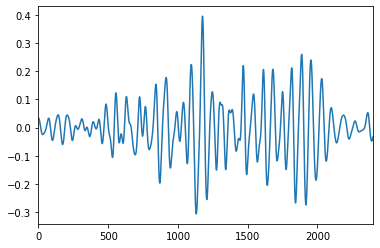

In [49]:
plt.plot(Ham)
plt.xlim(0,2400)

In [51]:
fourier = scipy.fft(Ham)

In [52]:
fourier

array([-0.25205581+0.j        , -0.25195559+0.03270575j,
       -0.25168673+0.0657917j , ..., -0.2511819 -0.09902773j,
       -0.25168673-0.0657917j , -0.25195559-0.03270575j])

Casting complex values to real discards the imaginary part


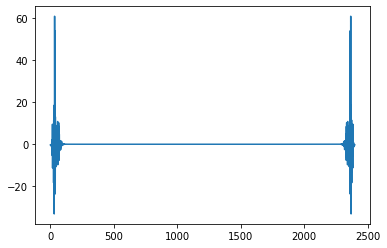

In [53]:
plt.plot(fourier)

In [54]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [55]:
fourier_2 = fourier_abs(fourier).real

In [56]:
fourier_2

array([0.25205581, 0.28466134, 0.31747842, ..., 0.35020963, 0.31747842,
       0.28466134])

(0, 2400)

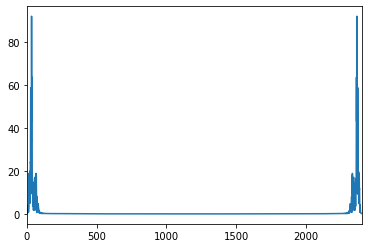

In [67]:
plt.plot(fourier_2)
plt.xlim(0,2400)

In [69]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

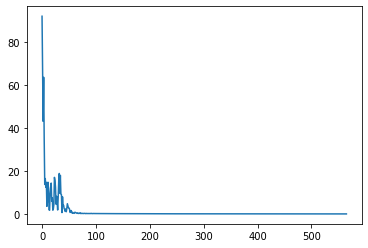

In [72]:
plt.plot(fourier_3)

In [63]:
time_2

2.0

In [74]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m)+range1)
print(m)

34
91.85441736088006


In [76]:
f.index(m)+34

34

In [42]:
f[6]

25.378390237140998

In [77]:
time_max_amp = (f.index(m)+34)/300 ## in seconds
if time_max_amp != 0:
    God_of_War = 1/time_max_amp
else:
    God_of_War = 0
God_of_War

8.823529411764707

In [78]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [79]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([0., 0., 0., ..., 0., 0., 0.])

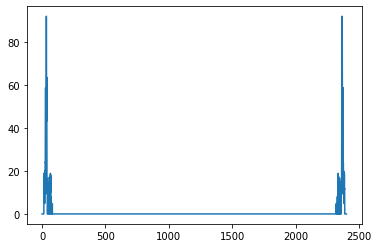

In [81]:
plt.plot(fourier_final)

In [82]:
def moment_calc(fourier,omega):
    j=0
    s=0
    fft = fourier[0:int(np.amin([20*omega,100]))]
    while j <= jmax:
        freq = 300/j   ##fix time
        m = 1/omega
        s = s + (m*freq)
        j+=1

In [83]:
pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],doplot="True",unit ='km / s' )

TypeError: 'module' object is not subscriptable

In [49]:
Mk = pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],unit = 'km / s').moments
Mk

<bound method BaseSpectrum.moments of <Spectrum object named  over spectral range      0 : 6.6639  and flux range = [0.0, 97.9] km / s at 0x1a82a82b86>>

In [50]:
np.minimum(1,2)

1

In [147]:
sum(fourier_final[range1:range2])

597.7263699636725

In [135]:
A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),fourier_final)
A1

0.0

In [137]:
A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),fourier_final)
A2

1.0

In [55]:
A = np.arange(2*God_of_War,8*God_of_War,0.6)
A = ((1/A)*t_cst).astype(int)
A = np.unique(A)
A

array([1, 2, 3, 4, 5, 6, 7])

In [190]:
A3_calc(fourier_final,God_of_War)

0.0396922751917916

In [322]:
def SPEC(signal):
    Ham = signal*np.hamming(2400)
    fourier = scipy.fft(Ham)
    fourier_2 = fourier_abs(fourier).real
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int((time_1*300))
    range2 = int((time_2*300))

    fourier_3 = fourier_2[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = (f.index(m)+range1)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    fourier_final = amp_maxsetter(fourier_2,m)
        
    A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),fourier_final)
    A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),fourier_final)
    A3 = A3_calc(fourier_final,God_of_War)
    
    return A1,A2,A3

In [323]:
def A_calc(f1,f2,f3,f4,signal):
    i1 = int((1/f1)*300)
    i2 = int((1/f2)*300)
    i3 = int((1/f3)*300)
    i4 = int((1/f4)*300)

    if i1<i2:
        A = sum(signal[i1:i2])
    else:
        A = sum(signal[i2:i1])
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])
    return (A/B)

In [324]:
def A3_calc(signal,God_of_War):
    A = np.arange(2*God_of_War,8*God_of_War,0.6)
    A = ((1/A)*t_cst).astype(int)
    A = np.unique(A)
    A = sum(signal[A])
    
    i3 = int((1/0.5)*300)
    i4 = int((1/np.minimum(20*God_of_War,100))*300)
    
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])
    return A/B

In [325]:
SPEC(sm[14040][0:2400])

(0.046171280190558446, 0.6919794659233124, 0.0396922751917916)

## SPEC TESTS:

#### With VF-VT:

In [339]:
counter1,counter2,counter3,counter4 = 0,0,0,0
for i in lismis:
    x = SPEC(sm[i][0:2400])
    if x[0] < 0.19:
        counter1+=1
    if x[1] >=0.45:
        counter2+=1
    if x[2] <= 0.09:
        counter3+=1
    if x[0] < 0.19 and  x[1] >=0.45 and x[2] <= 0.09 :
        counter4+=1

In [340]:
counter1/len(lismis)

0.9575971731448764

In [341]:
counter2/len(lismis)

0.18021201413427562

In [342]:
counter3/len(lismis)

0.08480565371024736

In [343]:
counter4/len(lismis)

0.038869257950530034

#### Without VF-VT:

In [344]:
counter1,counter2,counter3,counter4 = 0,0,0,0
for i in osmosis:
    x = SPEC(sm[i][0:2400])
    if x[0] < 0.19:
        counter1+=1
    if x[1] >=0.45:
        counter2+=1
    if x[2] <= 0.09:
        counter3+=1
    if x[0] < 0.19 and  x[1] >=0.45 and x[2] <= 0.09 :
        counter4+=1

In [345]:
1 - (counter1/len(osmosis))

0.016555579445280633

In [346]:
1 - (counter2/len(osmosis))

0.7380491650541102

In [347]:
1 - (counter3/len(osmosis))

0.9709739840894431

In [348]:
1 - (counter4/len(osmosis))

0.9777825557227836

## Spectral Extraction:

In [350]:
def SPEC_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(SPEC(ss[i][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SPEC_1","SPEC_2","SPEC_3"]
    return v

In [352]:
SPEC_DF = SPEC_ext(sm)

In [353]:
SPEC_DF

,SPEC_1,SPEC_2,SPEC_3
0,0.228939,0.328299,0.142407
1,0.059907,0.428035,0.179156
2,0.252563,0.332300,0.120658
3,0.061258,0.452158,0.161760
4,0.067158,0.421989,0.175807
5,0.184045,0.340671,0.166717
6,0.064157,0.444867,0.165120
7,0.051075,0.476496,0.180812
8,0.072867,0.430308,0.191738
9,0.057358,0.463199,0.180866


## Parameter 5: Complexity Measure Algorithm

In [457]:
nurgle = ss[2][0][0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

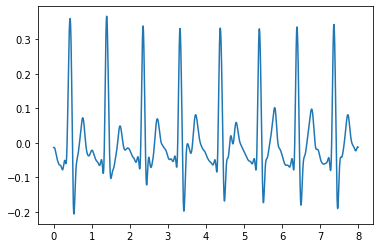

In [458]:
plt.plot(tt[2][0][0:2400],nurgle)

In [459]:
def Td(nurgle):
    meanbean = np.mean(nurgle)
    nurgle = nurgle - meanbean
    Vp = np.amax(nurgle)
    Vn = np.amin(nurgle)
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>nc:
        T = 0.2*Vn
    return T

In [460]:
Threshold = Td(nurgle)
Threshold

0

In [461]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [462]:
binary = binary_comp(Threshold,nurgle)
binary

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary,length):
    cn = 1
    S = [binary[0]]
    Q = [binary[1]]
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C=substrings(con)
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) == len(binary)-1:
                cn+=1
                break
            Q = [binary[len(S)]]
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+[binary[len(S)+m]]
                m+=1
            else:
                break
    bn = length/(math.log2(length))
    
    return cn/bn

In [32]:
def complexity_measure(nurgle,length):
    Threshold = Td(nurgle)
    binary = binary_comp(Threshold,nurgle)
    return complexity(binary,length)

In [465]:
def comp_measure(signal,length):
    l = 0
    k = 0
    j = 300
    for i in range(0,8):
        l += complexity_measure(signal[k:j],length)
        k+=300
        j+=300
    return l

In [466]:
complexity_measure(sm[14040][0:2400],2400) ## use an AWS for this

## Complexity measure tests:

## Complexity Measure Extraction:

In [ ]:
def Comp_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(comp_measure(ss[i][j][0:2400],2400))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Complexity"]
    return v

In [ ]:
Comp_DF = Comp_ext(ss)

## Parameter 6: Standard Exponential Algorithm

In [553]:
def std_exp_algthm(t,s,Tau):
    M = np.amax(s)
    tmax = (np.where(s==M))[0]/300 +t[0]
    exp_part = np.exp((-1*np.absolute(t-tmax))/Tau)
    curve = M*exp_part
    
    #plt.figure(figsize=(20,10))
    #plt.plot(t,s)
    #plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(s-curve))).flatten()
    #plt.plot(t[idx],s[idx],'ro')
    
    Time_length = len(s)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

In [554]:
std_exp_algthm(tm[195][0:2400],sm[195][0:2400],3)

142.5

## Standard Exponential Tests:

#### For VFVT :

In [561]:
counter = 0
for i in lismis:
    if std_exp_algthm(tm[i][0:2400],sm[i][0:2400],3) >= 180:
        counter+=1
counter

158

#### Without VFVT :

In [562]:
counter = 0
for i in osmosis:
    if std_exp_algthm(tm[i][0:2400],sm[i][0:2400],3) <= 180:
        counter+=1
counter

8610

## Standard Exponential Extraction:

In [563]:
def stdexp_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(std_exp_algthm(tt[i][0:2400],ss[i][0:2400],3))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["ST_EXP"]
    return v

In [564]:
ST_EXP_DF = stdexp_ext(sm,tm) 

In [565]:
ST_EXP_DF

,ST_EXP
0,135.0
1,112.5
2,97.5
3,127.5
4,172.5
5,97.5
6,127.5
7,97.5
8,112.5
9,157.5


## Parameter 7: Modified Exponential Algorithm

In [1]:
def MEA(t,ss,Tau):
    real_curve = [0.0]*len(t)
    index_M  = argrelextrema(ss,np.greater)
    idx_M = index_M[0]
    gladiator = np.amax(ss)
    idx_M2 = []
    for i in idx_M:
        if ss[i]>0.2*gladiator:
            idx_M2.append(i)
    idx_M2 = np.array(idx_M2)
    idx_M1 = []
    for i in idx_M:
        if ss[i]>0.1*gladiator:
            idx_M1.append(i)
    idx_M1 = np.array(idx_M1)
    
    ## draw the first curve
    pt = 0
    qqq = 0
    lifts=0
    while 2 < 3: 
        if pt >= idx_M[-1]: 
            break
        M1 = ss[pt]
        tm1 = t[pt]
        curve_1 = M1*np.exp(-1*(t-tm1)/(Tau))
        idx_1 = np.argwhere(np.diff(np.sign(ss-curve_1))).flatten()
        for i in idx_1:
            if i > 11+pt:
                idx_work = i
                break
        ## find all the maxes 
        for j in range(len(idx_M)):
            if idx_work <= idx_M[j]:
                idx_M_work = idx_M[j]
                break
        real_curve[pt:idx_work] = (curve_1[pt:idx_work])
        real_curve[idx_work:idx_M_work]=(ss[idx_work:idx_M_work])
        pt = idx_M_work
        if pt ==qqq:
            break
        qqq = idx_M_work
        lifts+=1
        if pt >= idx_M[-1]:     
            break
    idx_final = np.argwhere(np.diff(np.sign(ss-real_curve))).flatten()
    #plt.figure(figsize=(20,10))
    #plt.plot(t,ss,color="blue")
    #plt.plot(t,real_curve,color="green")
    #plt.plot(t[idx_final],ss[idx_final],'ro')
    pt=idx_M_work
    Time_length = t[-1]-t[0]
    form = lifts/Time_length
    return form*60

In [2]:
MEA(tm[6879][0:2400],sm[6879][0:2400],0.2)

NameError: name 'tm' is not defined

## MEA Tests:

In [246]:
counter = 0 
for i in lismis:
    if MEA(tm[i][0:2400],sm[i][0:2400],0.2) >= 180:
        counter+=1

In [247]:
counter

103

In [248]:
counter/len(lismis)*100

36.39575971731448

In [ ]:
counter = 0 
for i in osmosis:
    if MEA(tm[i][0:2400],sm[i][0:2400],0.2) <= 180:
        counter+=1
counter

In [ ]:
counter

In [ ]:
counter/len(osmosis) *100

## Modified Exponential Extraction:

In [606]:
def MEA_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(MEA(tt[i][0:-1],ss[i][0:-1],0.2))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["MDF_EXP"]
    return v

In [607]:
MEA_DF = MEA_ext(sm,tm)

In [608]:
MEA_DF

,MDF_EXP
0,144.667697
1,123.167155
2,121.076233
3,121.286371
4,124.962270
5,131.763208
6,128.372093
7,122.846929
8,124.606671
9,120.291616


## Parameter 8: Signal Comparison

In [661]:
signal = sm[14040][0:2400]
signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
time_1 = tm[14040][0:2400]
qrs_inds = processing.xqrs_detect(sig=signal, fs=150)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


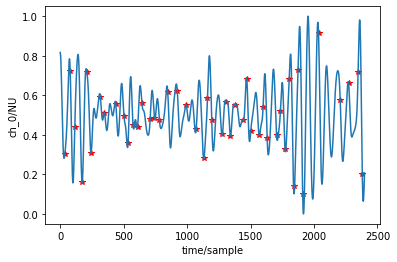

array([  37,   79,  115,  175,  210,  242,  317,  348,  438,  503,  535,
        574,  610,  644,  709,  743,  782,  848,  923,  993, 1072, 1130,
       1161, 1194, 1279, 1310, 1342, 1376, 1437, 1471, 1502, 1567, 1599,
       1631, 1705, 1736, 1772, 1805, 1839, 1874, 1911, 2036, 2207, 2273,
       2348, 2381])

In [662]:
wfdb.plot_items(signal=signal, ann_samp=[qrs_inds])
qrs_inds

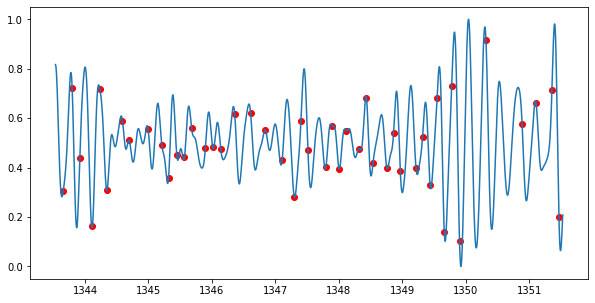

In [663]:
plt.figure(figsize=(10,5))
plt.plot(time_1,signal)
plt.scatter(time_1[qrs_inds],signal[qrs_inds],color="red")

Let's create the first signal:

In [614]:
MIT_signal_1 = sm[196*2]
time_1 = tm[196*2]

Adjust the peaks to match the QRS points found for the signal we want to examine:

In [615]:
SCA_1 = MIT_signal_1[0:2400]
qrs_inds_2 = processing.xqrs_detect(sig=SCA_1, fs=55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


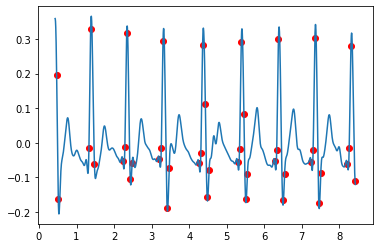

In [616]:
plt.plot(time_1[0:2400],SCA_1)
plt.scatter(time_1[qrs_inds_2],SCA_1[qrs_inds_2],color = "red")

Now to create the second signal:

In [617]:
avg = [sm[196][0:2400],sm[196*3][0:2400],sm[196*5][0:2400],sm[196*6][0:2400],sm[196*8][0:2400],sm[196*9][0:2400],sm[196*10][0:2400],sm[196*11][0:2400],
       sm[196*12][0:2400],sm[196*13][0:2400],sm[196*14][0:2400],sm[196*15][0:2400],sm[196*16][0:2400],sm[196*17][0:2400],sm[196*18][0:2400],sm[196*19][0:2400]]
avg = np.array(avg)

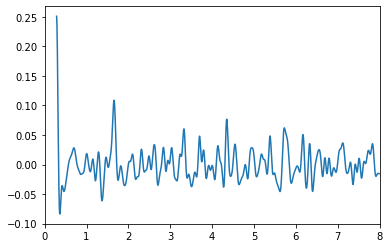

In [618]:
SCA_2 = sum(avg)/len(avg)
plt.xlim(0,8)
plt.plot(tm[196][0:2400],SCA_2)

In [619]:
SCA_2 = sm[196*3]

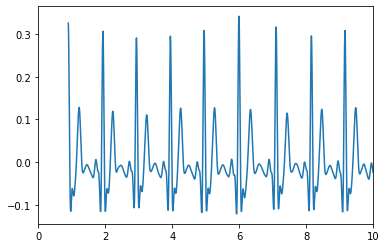

In [620]:
plt.xlim(0,10)
plt.plot(tm[196*3],SCA_2)

Now for the third signal, it just has an elevated T wave:

In [621]:
SCA_3 = sm[196*7]
time_third = tm[196*7]

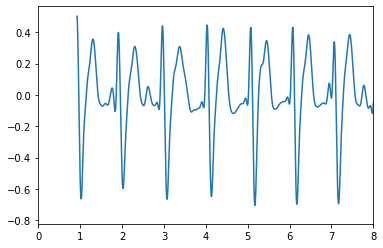

In [622]:
plt.xlim(0,8)
plt.plot(time_third,SCA_3)

For the fourth signal:

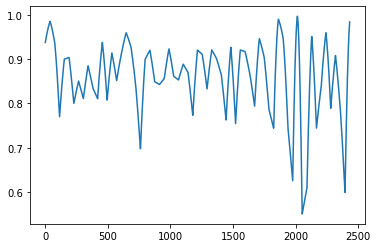

In [623]:
x = []
spacing1 = len(signal)/(len(qrs_inds)-1)
for i in range(len(signal[qrs_inds])-1):
    spacing2 = (signal[qrs_inds[i+1]] - signal[qrs_inds[i]])/spacing1
    y = np.arange(signal[qrs_inds[i]],signal[qrs_inds[i+1]],spacing2) ##Needs to be a formula
    for i in y:
        x.append(i)
x = np.array(x)
SCA_4 = np.cos(x)
plt.plot(SCA_4)
len(SCA_4)
SCA_4 = np.resize(SCA_4,(2400,))

Now for the residual calculation

In [624]:
I0 = qrs_inds[0]
I1 = qrs_inds[-1]

In [625]:
def Integral_calc(S,F,I0,I1):
    y = np.absolute(S-F)
    R = integrate.simps(y[I0:I1])
    return R

In [626]:
RF   = Integral_calc(signal,SCA_4,I0,I1)
RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
print("RF = ",RF)
print("RFS1 = ",RFS1)
print("RFS2 = ",RFS2)
print("RFS3 = ",RFS3)

RF =  846.7306000980315
RFS1 =  1202.6214513211437
RFS2 =  1201.3259400387906
RFS3 =  1213.104609184265


In [627]:
IF  = Integral_calc(SCA_4,0,I0,I1)
IE  = Integral_calc(signal,0,I0,I1)
IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)

print("IF = ",IF)
print("IE = ",IE)
print("IS1 = ",IS1)
print("IS2 = ",IS2)
print("IS3 = ",IS3)

IF =  2026.5510391859652
IE =  1200.1275762027683
IS1 =  160.8900068405989
IS2 =  122.80119010828646
IS3 =  409.5392890838373


In [628]:
VRF = (RF/min(IF,IE))
VRS1 = RFS1/min(IS1,IE)
VRS2 = RFS2/min(IS2,IE)
VRS3 = RFS3/min(IS3,IE)

print("VRF = ",VRF)
print("VRS1 = ",VRS1)
print("VRS2 = ",VRS2)
print("VRS3 = ",VRS3)

VRF =  0.7055338256430261
VRS1 =  7.474805147548014
VRS2 =  9.782689719696183
VRS3 =  2.962120220255422


In [629]:
t1 = VRF/VRS1
t2 = VRF/VRS2
t3 = VRF/VRS3

print("t1 = ",t1)
print("t2 = ",t2)
print("t3 = ",t3)

t1 =  0.0943882565118724
t2 =  0.07212063817403151
t3 =  0.23818541219849218


In [630]:
x= [1,2,3]
np.array(x)

array([1, 2, 3])

In [848]:
def SCA(signal):
    
    signal = wfdb.processing.normalize_bound(signal, lb=-1, ub=1)
    qrs_inds = processing.xqrs_detect(sig=signal, fs=150)
    
    if len(qrs_inds)<2:
        qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
        if len(qrs_inds)<2:
            signal = signal[300:-1]
            qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
            if len(qrs_inds)<2:
                qrs_inds = processing.xqrs_detect(sig=signal, fs=150)
                if len(qrs_inds)<2:
                    signal = signal[600:-1]
                    qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
                    if len(qrs_inds)<2:
                        qrs_inds = processing.xqrs_detect(sig=signal, fs=150)
                
    I0 = qrs_inds[0]
    I1 = qrs_inds[-1]
    
    RF   = Integral_calc(signal[0:2400],SCA_4,I0,I1)
    RFS1 = Integral_calc(signal[0:2400],SCA_1[0:2400],I0,I1)
    RFS2 = Integral_calc(signal[0:2400],SCA_2[0:2400],I0,I1)
    RFS3 = Integral_calc(signal[0:2400],SCA_3[0:2400],I0,I1)
    IF  = Integral_calc(SCA_4,0,I0,I1)
    IE  = Integral_calc(signal[0:2400],0,I0,I1)
    IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
    IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
    IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)
    VRF = (RF/min(IF,IE))
    VRS1 = RFS1/min(IS1,IE)
    VRS2 = RFS2/min(IS2,IE)
    VRS3 = RFS3/min(IS3,IE)
    t1 = VRF/VRS1
    t2 = VRF/VRS2
    t3 = VRF/VRS3
    
    l = [t1,t2,t3]
    
    return np.array(l)

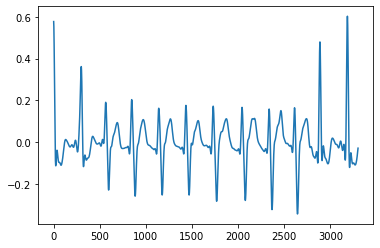

In [849]:
plt.plot(sm[861])

In [850]:
qrs_inds = processing.xqrs_detect(sig=sm[861], fs=150)
qrs_inds

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


array([  31,  302,  548,  597,  815,  857,  901, 1108, 1149, 1193, 1402,
       1444, 1486, 1699, 1741, 1785, 2011, 2054, 2096, 2305, 2370, 2401,
       2582, 2647, 2679, 2842, 2873, 2918, 3155, 3186, 3217])

In [851]:
SCA(sm[861])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


array([0.89287454, 0.67231101, 1.77897015])

## SCA TESTS:

In [852]:
%%capture
counter = 0
for i in lismis:
    x = SCA(sm[i])
    k=0
    for j in x:
        if j<=1:
            k+=1
    if k == 3:
        counter+=1

In [853]:
counter

121

In [854]:
counter/len(lismis)

0.4275618374558304

In [855]:
%%capture
counter = 0
for i in osmosis:
    x = SCA(sm[i])
    print(i)
    for j in x:
        if j>=1:
            counter+=1
            break

In [856]:
counter

7180

In [858]:
counter/len(osmosis)

0.5145846771303663

## SCA Extraction: 

In [334]:
def SCA_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(SCA(ss[i]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA_1","SCA_2","SCA_3"]
    return v

In [860]:
%%capture
SCA_DF = SCA_ext(sm)

ValueError: Length mismatch: Expected axis has 3 elements, new values have 1 elements

In [861]:
SCA_DF

NameError: name 'SCA_DF' is not defined

# Parameter 9: Wavelet Based Algorithms

## Wavelet 1: Algorithm:

In [252]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

(0, 2400)

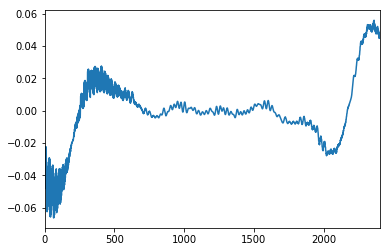

In [258]:
wavelet1 = pywt.cwt(sm[196][0:2400],200,"mexh")
plt.plot(wavelet1[0][0])
plt.xlim(0,2400)

Casting complex values to real discards the imaginary part


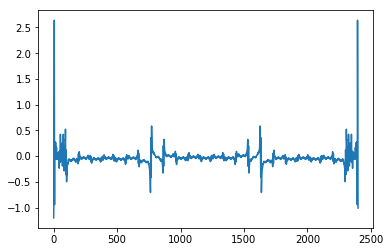

In [259]:
fourier1 = fft(wavelet1[0][0])
plt.plot(fourier1)

In [260]:
freq_cst = (1/(np.sqrt(2*np.pi)))

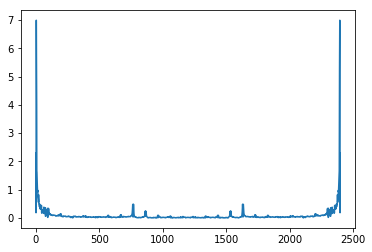

In [261]:
fourier1 = np.absolute(fourier1)
fourier1 = freq_cst*fourier1
plt.plot(fourier1)

(0, 10)

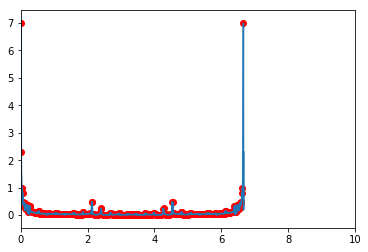

In [262]:
M = argrelextrema(fourier1,np.greater)[0]
plt.plot(time[0:len(fourier1)],fourier1)
plt.scatter(time[M],fourier1[M],color='red')
plt.xlim(0,10)

419

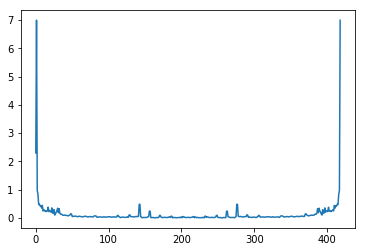

In [263]:
plt.plot(fourier1[M[0:2400]])
len(fourier1[M[0:2400]])

In [360]:
def SPEC2(signal):
    
    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int((time_1*300))
    range2 = int((time_2*300))

    ss = signal[range1:range2]
    
    m = np.amax(ss)
    f = ss.tolist()
    
    time_max_amp = (f.index(m)+range1)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
        
    A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),signal)
    A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),signal)
    A3 = A3_calc(signal,God_of_War)
    
    return A1,A2,A3

In [361]:
SPEC2(fourier1[M[0:2400]])

NameError: name 'fourier1' is not defined

In [362]:
def wavelet_one(signal):
    wavelet1 = pywt.cwt(signal,200,"mexh")
    fourier1 = fft(wavelet1[0][0])
    freq_cst = (1/(np.sqrt(2*np.pi)))
    fourier1 = np.absolute(fourier1)
    fourier1 = freq_cst*fourier1
    M = argrelextrema(fourier1,np.greater)[0]
    
    return SPEC2(fourier1[M[0:2400]])

In [368]:
wavelet_one(sm[10][0:2400])

(0.0, 0.5860063625426831, 0.008800394297311684)

## Wavelet 1 Extraction:

In [ ]:
def Wave1_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(wavelet_one(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

In [ ]:
Wave1_DF = Wave1_ext(ss)

## Wavelet 2 Algorithm:

Need to turn the SPEC algorithm into one big algorithm. This uses SPEC to check whether the signal is VF, if it is, then this second wavelet does not need to be considered. If it doesn't however, the following is performed:

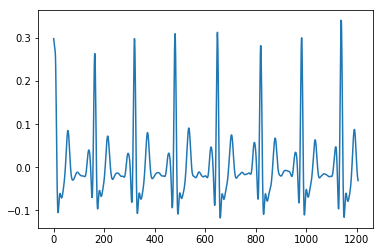

In [271]:
w = pywt.dwt(sm[196][0:2400],'db8','smooth')
plt.plot(w[0])

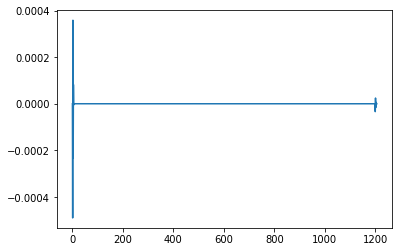

In [272]:
plt.plot(w[1])

In [273]:
qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=55)
len(qrs_wave2)/3

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

7.0

In [375]:
def Wave_2(signal):
    w = pywt.dwt(signal[0:2400],'db8','smooth')
    qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=41)
    return len(qrs_wave2)/3

In [376]:
%%capture
x = Wave_2(sm[14040][0:2400])

In [377]:
x

22.333333333333332

## Wavelet 2 Extraction:

In [ ]:
def Wave2_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(Wave_2(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

# Parameter 10: Li Algorithm

I used the continuous wavelet instead, as it allows for scaling:

In [30]:
def wavelet_finder(signal):
    signal = wfdb.processing.normalize_bound(signal, lb=-1, ub=1)
    w1 = pywt.cwt(signal,2,'mexh')
    #plt.plot(w1[0][0])
    
    w2 = pywt.cwt(signal,np.power(2,2),'mexh')
    #plt.figure()
    #plt.plot(w2[0][0])
    
    w3 = pywt.cwt(signal,np.power(2,3),'mexh')
    #plt.figure()
    #plt.plot(w3[0][0])
    
    w4 = pywt.cwt(signal,np.power(2,4),'mexh')
    #plt.figure()
    #plt.plot(w4[0][0])
    
    return w1[0][0],w2[0][0],w3[0][0],w4[0][0]

In [31]:
w1,w2,w3,w4 = wavelet_finder(sm[14040][0:2400])

In [32]:
w1,time1 = signal_preprocessor(w1,tm[14040],50,30)
w2,time2 = signal_preprocessor(w2,tm[14040],50,30)
w3,time3 = signal_preprocessor(w3,tm[14040],50,30)
w4,time4 = signal_preprocessor(w4,tm[14040],50,30)

In [33]:
def QRS_number_search(w1,w2,w3,w4,fs):
    qrs_w1 = processing.xqrs_detect(sig=w1, fs=50)
    qrs_w2 = processing.xqrs_detect(sig=w2, fs=50)
    qrs_w3 = processing.xqrs_detect(sig=w3, fs=50)
    qrs_w4 = processing.xqrs_detect(sig=w4, fs=50)
    
    return qrs_w1,qrs_w2,qrs_w3,qrs_w4

In [34]:
qrs1,qrs2,qrs3,qrs4 = QRS_number_search(w1,w2,w3,w4,50)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


33.333333333333336
35.0
36.0
38.333333333333336


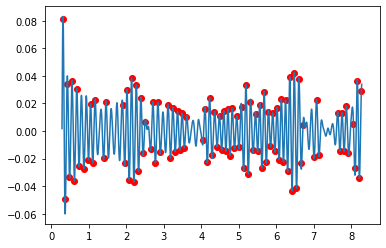

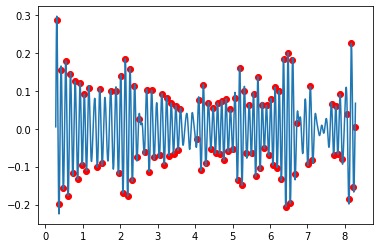

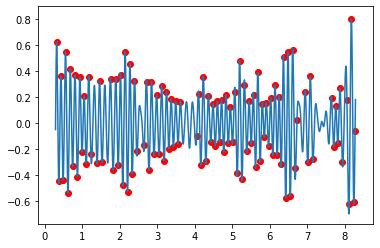

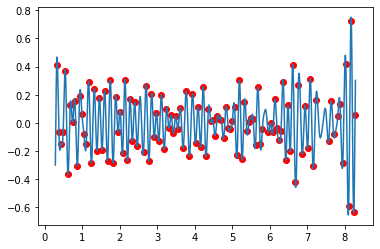

In [35]:
plt.plot(tm[196][0:2400],w1)
plt.scatter(tm[196][qrs1],w1[qrs1],color="red")
print(len(qrs1)/3)

plt.figure()

plt.plot(tm[196][0:2400],w2)
plt.scatter(tm[196][qrs2],w2[qrs2],color="red")
print(len(qrs2)/3)

plt.figure()

plt.plot(tm[196][0:2400],w3)
plt.scatter(tm[196][qrs3],w3[qrs3],color="red")
print(len(qrs3)/3)

plt.figure()

plt.plot(tm[196][0:2400],w4)
plt.scatter(tm[196][qrs4],w4[qrs4],color="red")
print(len(qrs4)/3)

0 or greater than 5 times the window length in seconds, so 40 in the 8 second interval case

In [36]:
def Li_Algthm(s,t):
    w1,w2,w3,w4 = wavelet_finder(s[0:2400])
    
    w1,time1 = signal_preprocessor(w1,t,50,30)
    w2,time2 = signal_preprocessor(w2,t,50,30)
    w3,time3 = signal_preprocessor(w3,t,50,30)
    w4,time4 = signal_preprocessor(w4,t,50,30)
    
    qrs1,qrs2,qrs3,qrs4 = QRS_number_search(w1,w2,w3,w4,50)
    
    array = [len(qrs1)/3,len(qrs2)/3,len(qrs3)/3,len(qrs4)/3]
    
    return np.array(array)
    

In [37]:
%%capture
start_time = time.time()
x = Li_Algthm(sm[14040],tm[14040])
y = time.time()-start_time

In [38]:
x

array([33.33333333, 35.        , 36.        , 38.33333333])

In [39]:
y

0.10273027420043945

## Li Algorithm Tests:

#### With VF-VT :

In [46]:
%%capture
counter=0
for i in lismis:
    x = Li_Algthm(sm[i],tm[i])
    for j in x:
        if j >=30:
            counter+=1
            break

In [47]:
counter

136

In [48]:
counter/len(lismis)

0.48056537102473496

#### Without VF-VT:

In [49]:
%%capture
counter=0
for i in osmosis:
    x = Li_Algthm(sm[i],tm[i])
    for j in x:
        if j >=30:
            counter+=1
            break

In [50]:
counter

2768

In [51]:
1 - (counter/len(osmosis))

0.8016197233569842

## Li Algorithm Extraction

In [ ]:
def Li_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(Li_Algthm(ss[i],tt[i]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Li_1","Li_2","Li_3","Li_4"]
    return v

In [ ]:
Li_DF = Li_ext(ss,tt)

In [ ]:
Li_DF

# Parameter 11: Tompkins Algorithm

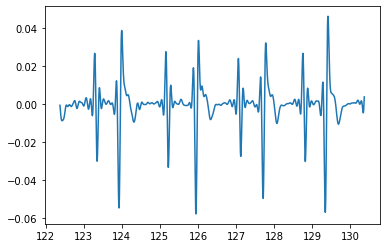

In [54]:
sig = np.gradient(sm[4519][0:2400],edge_order=1)
plt.plot(tm[4519][0:2400],sig)

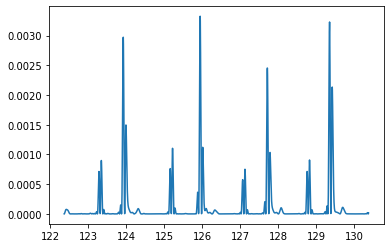

In [55]:
signal = np.power(sig,2)
plt.plot(tm[4519][0:2400],signal)

In [56]:
time2 = tm[4519][0:2400]
time2.shape

(2400,)

In [57]:
signal.shape

(2400,)

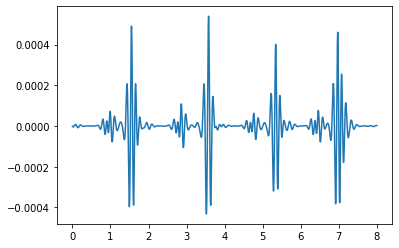

In [58]:
sigmig,time3 = signal_preprocessor(signal,time2,50,30)
sigmig = np.array(sigmig)
plt.plot(time3,sigmig)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


13.0

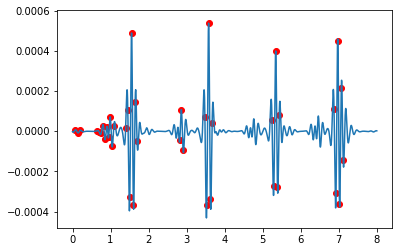

In [59]:
qrs = processing.xqrs_detect(sig=sigmig, fs=50)
plt.plot(time3,sigmig)
plt.scatter(time3[qrs],sigmig[qrs],color="Red")
len(qrs)/3

In [125]:
def Tompkins(ss,tt):
    sig = np.gradient(ss[0:2400],edge_order=1)
    signal = np.power(sig,2)
    sigmig,time3 = signal_preprocessor(signal,tt,30,30)
    sigmig = np.array(sigmig)
    qrs = processing.xqrs_detect(sig=sigmig, fs=41)
    
    return len(qrs)/3

In [126]:
Tompkins(sm[0],tm[0])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


20.0

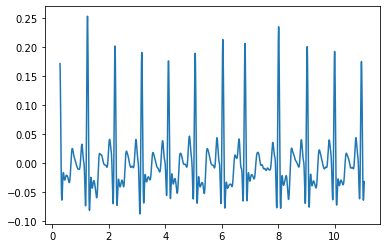

In [127]:
plt.plot(tm[0],sm[0])

## Tompkins Tests:

#### With VF-VT :

In [128]:
%%capture
counter = 0
for i in lismis:
    if Tompkins(sm[i],tm[i]) >=32 or Tompkins(sm[i],tm[i]) <= 2:
        counter +=1

In [129]:
counter

96

In [130]:
counter/len(lismis)

0.3392226148409894

#### Without VF-VT :

In [131]:
%%capture
counter = 0
for i in osmosis:
    if Tompkins(sm[i],tm[i]) <=32 or Tompkins(sm[i],tm[i]) >= 2:
        counter +=1

In [132]:
counter

13953

In [133]:
counter/len(osmosis)

1.0

## Tompkins Extraction:

In [ ]:
def Tompkins_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(Tompkins(ss[i],tt[i]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Tompkins"]
    return v

In [ ]:
Tompkins_DF = Tompkins_ext(sm,tm)

In [ ]:
Tompkins_DF

# Parameter 12: Mean Absolute Value Algorithm

In [135]:
def mav(signal,I1,I2):
    s = 0
    sig = signal/np.amax(np.absolute(signal))
    for i in sig[I1:I2]:
        s+=np.absolute(i)
    return s/len(signal)

In [136]:
mav(ss[2][0][0:2400],0,300)

0.02644043557461253

In [137]:
np.arange(0,int(len(ss[2][0][0:2400])/300)-1,1)

array([0, 1, 2, 3, 4, 5, 6])

In [138]:
def mav_avg(signal,length):
    L = (length-1)
    ran = np.arange(0,int(len(signal)/300)-2,1)
    I1 = 0
    I2= 600
    mavi = []
    for i in ran:
        mavi.append(7*mav(signal,I1,I2))
        I1+=300
        I2+=300
    avg_mav = np.mean(mavi)
    return avg_mav

In [139]:
mav_avg(ss[100][22][0:2400],2)

0.28161079226184715

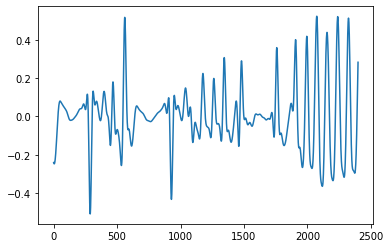

In [140]:
plt.plot(ss[100][22][0:2400])

## MAV Tests:

#### With VF-VT :

In [141]:
counter = 0
for i in lismis:
    if mav_avg(sm[i],2) >= 0.27:
        counter+=1
counter

123

In [142]:
counter/len(lismis)

0.43462897526501765

#### Without VF-VT : 

In [143]:
counter = 0
for i in osmosis:
    if mav_avg(sm[i],2) <= 0.27:
        counter+=1
counter

9797

In [144]:
counter/len(osmosis)

0.702142908335125

## MAV Extraction:

In [146]:
def MAV_ext(ss):
    values = []
    for i in range(len(ss)):
        values.append(mav_avg(ss[i],2))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["MAV"]
    return v

In [147]:
MAV_DF = MAV_ext(sm)

In [148]:
MAV_DF

,MAV
0,0.167853
1,0.159666
2,0.155569
3,0.175530
4,0.148831
5,0.148456
6,0.188599
7,0.149938
8,0.163904
9,0.138882


Note that the threshold for VF-VT is 0.27